# Dataset generator

## Inputs:
 - Daily ground truth per lake stored in data/gt
 - Rasters in tiff format stored in data/rasters/sentinel1, with the structure: winter/orientation/lake/band

## Outputs:
 - RGB composite from SAR images
 - pixel-wise ground truth:
     - Non transition dates (either fully non-frozen or frozen):
         - r -> non-frozen
         - b -> frozen
         - w -> background
     - Transition dates:
         - for training set no output is generated
         - for validation set, completely white gt label is generated, then it's ignored in quantification statistics

In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import rasterio.mask
import numpy as np
import fiona
import os
from PIL import Image
import json

In [2]:
water_count = [0,0,0,0]
snow_count = [0,0,0,0]
ice_count = [0,0,0,0]
transition_count = [0,0,0,0]
no_class_count = [0,0,0,0]

val_count = 0
train_count = 0

In [19]:
# change to json format for storing tests

val_param = ["2016_17"] # type here one lake or one winter, to be included in the validation set
sensor = "sentinel1"
sessions = ["2016_17", "2017_18"]
polarizations = ["vv", "vh"]
orbit_passes = ["desc", "asc"]
lakes = ["sils", "silvaplana", "stmoritz"]

output_name = ""
for s in sessions:
    output_name = output_name + s + "_" 
for p in polarizations:
    output_name = output_name + p + "_" 
for l in lakes:
    output_name = output_name + l + "_" 
if len(val_param) > 0:
    output_name = output_name + "val_".join([x for x in val_param])
print(output_name)

input_path = os.path.abspath("../data")
gt_folder = os.path.join(input_path, "gt")
output_path = os.path.abspath("../models/research/deeplab/datasets/sar_ice")
output_folder = os.path.join(output_path, "dataset_"+output_name)

os.makedirs(output_folder,exist_ok=True)
deeplab_dataset_folders = ["ImageSets", "JPEGImages", "SegmentationClass", "SegmentationClassRaw"]
for deeplab_dataset_folder in deeplab_dataset_folders:
    os.makedirs(os.path.join(output_folder, deeplab_dataset_folder), exist_ok=True)
    
valtxt = os.path.join(output_folder, "ImageSets", "val.txt")
traintxt = os.path.join(output_folder, "ImageSets", "train.txt")
trainvaltxt = os.path.join(output_folder, "ImageSets", "trainval.txt")

size = 32

2016_17_2017_18_vv_vh_sils_silvaplana_stmoritz_2016_17


In [20]:
def get_mask(raster, geometry):
    out_image, out_transform = rasterio.mask.mask(raster, [geometry], nodata=np.nan, crop=True, pad=True, pad_width=size)
    return out_image    

In [21]:
def get_masked_image(image):
    image = image[0]*255
    image[np.isnan(image)] = 255
    return image

In [22]:
def get_masked_image2(pols):    
   
    w = pols[0][0].shape[0]
    h = pols[0][0].shape[1]
    if len(pols) > 1:
        w = min(pols[0][0].shape[0], pols[1][0].shape[0])
        h = min(pols[0][0].shape[1], pols[1][0].shape[1])

    rgbImage = np.full((w,h,3), 0, 'uint8')

    for idx, pol in enumerate(pols):
        image = pol[0]*255
    
        image = image[0:w, 0:h]
        image[np.isnan(image)] = 255
        rgbImage[:,:,idx] = image
    if (len(pols) == 1):
        rgbImage[rgbImage[:,:,0] == 255,1] = 255
    rgbImage[rgbImage[:,:,1] == 255,2] = 255
    plt.imshow(rgbImage)
    return rgbImage

In [23]:
def get_rgb_mask(image, class_type,shapeX):

    rgbMask = np.full((shapeX[0],shapeX[1],3), 255, 'uint8')

    image = image[0:shapeX[0],0:shapeX[1]]
    image[~np.isnan(image)]  = 0
    image[np.isnan(image)]  = 255
        
    if class_type is "w": # lake mask region = red
        rgbMask[:,:,1] = image
        rgbMask[:,:,2] = image    
    elif class_type is "f":  # lake mask region = green
        rgbMask[:,:,0] = image
        rgbMask[:,:,1] = image
        
    return rgbMask

In [24]:
def get_indexed_mask(mask, class_type, shapeX):

    mask = mask[0:shapeX[0],0:shapeX[1]]
    if class_type is "w":
        mask[~np.isnan(mask)]  = 2
    elif class_type is "f":
        mask[~np.isnan(mask)]  = 1
    mask[np.isnan(mask)]  = 0
    return mask

In [25]:
def get_gt_name(filename, lake):
    date = filename.split('_')[4]
    year = date[0:4]
    month = date[4:6]
    day = date[6:8]
    name = "_"+year+"_"+month+"_"+day+"_"+date[9:13]+"_"+lake
    return name

In [26]:
def with_transitions(is_val):
    if transitions is "tran" and is_val:
        return True
    return False

In [27]:
def get_class(manual_label, lake, is_val):
    
    global transition_count
    global water_count
    global snow_count
    global ice_count
    global no_class_count    
    
    if "n" in manual_label or "c" in manual_label or "u" in manual_label:
        transition_count[lakes.index(lake)] = transition_count[lakes.index(lake)] + 1
        return "t"
    if "ms" in manual_label or "mi" in manual_label or "mw" in manual_label or "w/s" in manual_label:      
        transition_count[lakes.index(lake)] = transition_count[lakes.index(lake)] + 1
        return "t"
    if "w" in manual_label:
        water_count[lakes.index(lake)] = water_count[lakes.index(lake)] + 1
        return "w"
    
    if "s" in manual_label or "i" in manual_label:
        if "i/s" in manual_label:
            ice_count[lakes.index(lake)] =  ice_count[lakes.index(lake)] + 1
        elif "s" in manual_label:
            snow_count[lakes.index(lake)] = snow_count[lakes.index(lake)] + 1
        elif "i" in manual_label:
            ice_count[lakes.index(lake)] =  ice_count[lakes.index(lake)] + 1
        return "f"
    return "t"

In [28]:
def get_ground_truth_date(sar_image_file, gt_file, is_val, lake, isOptical = False):
    global transition_count
    class_type = "t"

    month = -1
    day = -1
    if isOptical:
        month = int(sar_image_file[4:6])
        day = int(sar_image_file[6:8])
    else:
        capture_date = sar_image_file.split('_')[4]
        month = int(capture_date[4:6])
        day = int(capture_date[6:8])


        month = int(capture_date[4:6])
        day = int(capture_date[6:8])
    f= open(gt_file,"r")
    while True:
        line = f.readline()
        if "-9999" in line:
            break
    while True:
        line = f.readline()
        if ("" == line):
            break
        try:
            line_date = line.split(' ')[0]
            line_day = int(line_date.split('.')[0])
            line_month = int(line_date.split('.')[1])
            if line_day == day and line_month == month:
                print(line)
                class_type = get_class(line.split(' ')[1], lake, is_val)
                break
        except:
            continue
    f.close()
    return class_type

In [29]:
def get_masked_lake(raster, shp_feature, class_type, p, is_morning, sar_image_name):
    geometry = shp_feature['geometry']
    lake_masked = get_mask(raster, geometry)
    return lake_masked

In [30]:
def normalise_raster(raster):
    raster[raster < -45] = -45
    raster[raster > 5] = 5
    return (raster+45)/50

In [31]:
def store_images(image, rgbMask, mask, output_name, is_val, class_type):
    global val_count
    global train_count
    if is_val:     
        f_valtxt.write(output_name+"\n") 
        f_trainvaltxt.write(output_name+"\n")
        val_count = val_count + 1
    elif class_type is not "t":
        f_traintxt.write(output_name+"\n")  
        f_trainvaltxt.write(output_name+"\n")
        train_count = train_count + 1
    output_name = output_name+".png"
    output_segmentation = os.path.join(output_folder, "SegmentationClass", output_name)
    output_segmentationRaw = os.path.join(output_folder, "SegmentationClassRaw", output_name)
    output_image = os.path.join(output_folder, "JPEGImages", output_name)
    im = Image.fromarray(np.uint8(rgbMask))
    print(im.save(output_segmentation))
    im = Image.fromarray(np.uint8(mask))
    print(im.save(output_segmentationRaw))
    im = Image.fromarray(np.uint8(image))
    print(im.save(output_image))
    plt.imshow(image)
    print(output_name)

In [32]:
def generate_deeplab_format(input_folder, sar_image_name, session, lake, is_val):

    shp_file = os.path.join(input_path, "shapes", "UTM32N.shp")
    shapefile = fiona.open(shp_file)
    shape_index = 0
    if lake == "stmoritz":
        shape_index = 1
    elif lake == "silvaplana":
        shape_index = 2
    elif lake == "sils":
        shape_index = 3
    elif lake == "sihl":
        shape_index = 4
    elif lake == "lacdejoux":
        shp_file = os.path.join(input_path, "shapes", "UTM31N.shp")
        shape_index = 0
    shp_feature = shapefile[shape_index]
    logscaled_masked_lake = []
    
    gt_name = os.path.join(gt_folder, session, lake+".txt")

    class_type = get_ground_truth_date(sar_image_name, gt_name, is_val, lake)

    for p in polarizations:
        raster_name = os.path.join(input_folder, p, sar_image_name)
        raster = rasterio.open(raster_name)
        masked_lake = get_masked_lake(raster, shp_feature, class_type, p, ("T05" in sar_image_name), sar_image_name)
        logscaled_masked_lake.append(normalise_raster(masked_lake))

    image = get_masked_image2(logscaled_masked_lake)
    rgbMask = get_rgb_mask(masked_lake[0].copy(), class_type, image.shape)
    mask = get_indexed_mask(masked_lake[0].copy(), class_type, image.shape)
    output_name = get_gt_name(sar_image_name, lake)
    store_images(image, rgbMask, mask, output_name, is_val, class_type)
    return True
    

In [33]:
f_valtxt = open(valtxt, "w")
f_traintxt = open(traintxt, "w")
f_trainvaltxt = open(trainvaltxt, "w")

S1A_IW_GRDH_1SDV_20160905T053500_20160905T053525_012913_01469F_6D95.tif
05.09 w

None
None
None
_2016_09_05_0535_sils.png
S1A_IW_GRDH_1SDV_20160912T052642_20160912T052707_013015_0149CC_B21E.tif
12.09 w

None
None


/home/romartinez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/romartinez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


None
_2016_09_12_0526_sils.png
S1A_IW_GRDH_1SDV_20160917T053501_20160917T053526_013088_014C43_B155.tif
17.09 w

None
None
None
_2016_09_17_0535_sils.png
S1A_IW_GRDH_1SDV_20160924T052643_20160924T052708_013190_014FA5_5A44.tif
24.09 w

None
None
None
_2016_09_24_0526_sils.png
S1A_IW_GRDH_1SDV_20160929T053501_20160929T053526_013263_0151F9_5363.tif
29.09 w

None
None
None
_2016_09_29_0535_sils.png
S1B_IW_GRDH_1SDV_20160930T052604_20160930T052629_002294_003E0C_CEAA.tif
30.09 w

None
None
None
_2016_09_30_0526_sils.png
S1A_IW_GRDH_1SDV_20161006T052643_20161006T052708_013365_015521_D387.tif
6.10 w s/ms

None
None
None
_2016_10_06_0526_sils.png
S1A_IW_GRDH_1SDV_20161011T053501_20161011T053526_013438_01577F_1B4A.tif
11.10 w c no snow

None
None
None
_2016_10_11_0535_sils.png
S1A_IW_GRDH_1SDV_20161018T052643_20161018T052708_013540_015AB8_9F29.tif
18.10 mw mc a bit unclear (w->mi improbable especially in beginning of october so updated to mw)

None
None
None
_2016_10_18_0526_sils.png
S1A_IW_GRDH_

2.10 w mc/c

None
None
None
_2016_10_02_1706_sils.png
S1A_IW_GRDH_1SDV_20161007T171454_20161007T171519_013387_0155CD_6FED.tif
7.10 w ms

None
None
None
_2016_10_07_1714_sils.png
S1A_IW_GRDH_1SDV_20161014T170644_20161014T170709_013489_015911_13FF.tif
14.10 w c fog and low clouds (wwwwww->u->u->mw, probably both the u are either mw or w, assigned mw)

None
None
None
_2016_10_14_1706_sils.png
S1A_IW_GRDH_1SDV_20161019T171454_20161019T171519_013562_015B60_2748.tif
19.10 mw <- mi mc

None
None
None
_2016_10_19_1714_sils.png
S1A_IW_GRDH_1SDV_20161026T170644_20161026T170709_013664_015E7F_F608.tif
26.10 w c

None
None
None
_2016_10_26_1706_sils.png
S1A_IW_GRDH_1SDV_20161031T171454_20161031T171519_013737_0160BD_F917.tif
31.10 mw s  (improbable transition mi->w, so updated to mw)

None
None
None
_2016_10_31_1714_sils.png
S1A_IW_GRDH_1SDV_20161107T170644_20161107T170709_013839_0163F7_DB28.tif
7.11 mw ms probably top part frozen

None
None
None
_2016_11_07_1706_sils.png
S1A_IW_GRDH_1SDV_20161112T1

None
_2016_09_12_0526_silvaplana.png
S1A_IW_GRDH_1SDV_20160917T053501_20160917T053526_013088_014C43_B155.tif
17.09 w

None
None
None
_2016_09_17_0535_silvaplana.png
S1A_IW_GRDH_1SDV_20160924T052643_20160924T052708_013190_014FA5_5A44.tif
24.09 w

None
None
None
_2016_09_24_0526_silvaplana.png
S1A_IW_GRDH_1SDV_20160929T053501_20160929T053526_013263_0151F9_5363.tif
29.09 w

None
None
None
_2016_09_29_0535_silvaplana.png
S1B_IW_GRDH_1SDV_20160930T052604_20160930T052629_002294_003E0C_CEAA.tif
30.09 w

None
None
None
_2016_09_30_0526_silvaplana.png
S1A_IW_GRDH_1SDV_20161006T052643_20161006T052708_013365_015521_D387.tif
6.10 w mc/ms

None
None
None
_2016_10_06_0526_silvaplana.png
S1A_IW_GRDH_1SDV_20161011T053501_20161011T053526_013438_01577F_1B4A.tif
11.10 w ms/mc 

None
None
None
_2016_10_11_0535_silvaplana.png
S1A_IW_GRDH_1SDV_20161018T052643_20161018T052708_013540_015AB8_9F29.tif
18.10 w c/mc probably water

None
None
None
_2016_10_18_0526_silvaplana.png
S1A_IW_GRDH_1SDV_20161023T053501_20

None
None
None
_2016_09_20_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20160925T171454_20160925T171519_013212_015050_030F.tif
25.09 w

None
None
None
_2016_09_25_1714_silvaplana.png
S1B_IW_GRDH_1SDV_20160926T170602_20160926T170627_002243_003C54_03E3.tif
26.09 w

None
None
None
_2016_09_26_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20161002T170644_20161002T170709_013314_015387_082A.tif
2.10 w mc/c probably water

None
None
None
_2016_10_02_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20161007T171454_20161007T171519_013387_0155CD_6FED.tif
7.10 w c/mc

None
None
None
_2016_10_07_1714_silvaplana.png
S1A_IW_GRDH_1SDV_20161014T170644_20161014T170709_013489_015911_13FF.tif
14.10 w c fog and low clouds

None
None
None
_2016_10_14_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20161019T171454_20161019T171519_013562_015B60_2748.tif
19.10 w c/mc probably more water (Sentinel2: probably water)

None
None
None
_2016_10_19_1714_silvaplana.png
S1A_IW_GRDH_1SDV_20161026T170644_20161026T170709_013664_015E7F_F608.tif
26.10 w c low cl

None
None
None
_2017_05_18_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20170523T171447_20170523T171512_016712_01BC02_A875.tif
23.05 w

None
None
None
_2017_05_23_1714_silvaplana.png
S1B_IW_GRDH_1SDV_20170524T170600_20170524T170625_005743_00A0F5_9C9B.tif
24.05 w

None
None
None
_2017_05_24_1706_silvaplana.png
S1B_IW_GRDH_1SDV_20170529T171410_20170529T171435_005816_00A31A_0C6D.tif
29.05 w

None
None
None
_2017_05_29_1714_silvaplana.png
S1A_IW_GRDH_1SDV_20170530T170644_20170530T170709_016814_01BF29_270A.tif
30.05 w

None
None
None
_2017_05_30_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20160905T053500_20160905T053525_012913_01469F_6D95.tif
05.09 w

None
None
None
_2016_09_05_0535_stmoritz.png
S1A_IW_GRDH_1SDV_20160912T052642_20160912T052707_013015_0149CC_B21E.tif
12.09 w

None
None
None
_2016_09_12_0526_stmoritz.png
S1A_IW_GRDH_1SDV_20160917T053501_20160917T053526_013088_014C43_B155.tif
17.09 w

None
None
None
_2016_09_17_0535_stmoritz.png
S1A_IW_GRDH_1SDV_20160924T052643_20160924T052708_013190_014FA5_

None
_2016_09_25_1714_stmoritz.png
S1B_IW_GRDH_1SDV_20160926T170602_20160926T170627_002243_003C54_03E3.tif
26.09 w

None
None
None
_2016_09_26_1706_stmoritz.png
S1A_IW_GRDH_1SDV_20161002T170644_20161002T170709_013314_015387_082A.tif
2.10 w

None
None
None
_2016_10_02_1706_stmoritz.png
S1A_IW_GRDH_1SDV_20161007T171454_20161007T171519_013387_0155CD_6FED.tif
7.10 w

None
None
None
_2016_10_07_1714_stmoritz.png
S1A_IW_GRDH_1SDV_20161014T170644_20161014T170709_013489_015911_13FF.tif
14.10 w

None
None
None
_2016_10_14_1706_stmoritz.png
S1A_IW_GRDH_1SDV_20161019T171454_20161019T171519_013562_015B60_2748.tif
19.10 w probably water

None
None
None
_2016_10_19_1714_stmoritz.png
S1A_IW_GRDH_1SDV_20161026T170644_20161026T170709_013664_015E7F_F608.tif
26.10 w

None
None
None
_2016_10_26_1706_stmoritz.png
S1A_IW_GRDH_1SDV_20161031T171454_20161031T171519_013737_0160BD_F917.tif
31.10 w

None
None
None
_2016_10_31_1714_stmoritz.png
S1A_IW_GRDH_1SDV_20161107T170644_20161107T170709_013839_0163F7_DB28.ti

None
None
None
_2017_09_24_0535_sils.png
S1B_IW_GRDH_1SDV_20170925T052601_20170925T052626_007544_00D51A_8411.tif
25.09 w

None
None
None
_2017_09_25_0526_sils.png
S1B_IW_GRDH_1SDV_20170930T053414_20170930T053439_007617_00D737_8657.tif
30.09 w

None
None
None
_2017_09_30_0534_sils.png
S1A_IW_GRDH_1SDV_20171001T052700_20171001T052725_018615_01F62C_91DA.tif
01.10 w

None
None
None
_2017_10_01_0527_sils.png
S1A_IW_GRDH_1SDV_20171006T053513_20171006T053538_018688_01F871_E3CA.tif
06.10 w

None
None
None
_2017_10_06_0535_sils.png
S1B_IW_GRDH_1SDV_20171007T052601_20171007T052626_007719_00DA22_B9C5.tif
07.10 w

None
None
None
_2017_10_07_0526_sils.png
S1B_IW_GRDH_1SDV_20171012T053414_20171012T053439_007792_00DC33_9248.tif
12.10 w

None
None
None
_2017_10_12_0534_sils.png
S1A_IW_GRDH_1SDV_20171013T052700_20171013T052725_018790_01FB7E_0E19.tif
13.10 w

None
None
None
_2017_10_13_0527_sils.png
S1A_IW_GRDH_1SDV_20171018T053513_20171018T053538_018863_01FDCC_566D.tif
18.10 w

None
None
None
_2017_10_

None
_2018_04_17_0526_sils.png
S1B_IW_GRDH_1SDV_20180422T053408_20180422T053433_010592_01352D_A20C.tif
22.04 ms/mi

None
None
None
_2018_04_22_0534_sils.png
S1A_IW_GRDH_1SDV_20180423T052658_20180423T052723_021590_025363_A9B9.tif
23.04 ms/mi

None
None
None
_2018_04_23_0526_sils.png
S1A_IW_GRDH_1SDV_20180428T053511_20180428T053536_021663_0255BA_0AFB.tif
28.04 mi

None
None
None
_2018_04_28_0535_sils.png
S1B_IW_GRDH_1SDV_20180429T052603_20180429T052628_010694_013876_CD42.tif
29.04 mi

None
None
None
_2018_04_29_0526_sils.png
S1B_IW_GRDH_1SDV_20180504T053408_20180504T053433_010767_013AD2_1401.tif
04.05 mi/mw

None
None
None
_2018_05_04_0534_sils.png
S1A_IW_GRDH_1SDV_20180505T052659_20180505T052724_021765_0258EB_2561.tif
05.05 mw

None
None
None
_2018_05_05_0526_sils.png
S1A_IW_GRDH_1SDV_20180510T053512_20180510T053537_021838_025B48_90A6.tif
10.05 mw

None
None
None
_2018_05_10_0535_sils.png
S1B_IW_GRDH_1SDV_20180511T052604_20180511T052629_010869_013E1D_F9FD.tif
11.05 mw

None
None
None
_2

None
None
None
_2018_02_05_1714_sils.png
S1A_IW_GRDH_1SDV_20180206T170647_20180206T170712_020489_0230A8_CEBB.tif
06.02 s

None
None
None
_2018_02_06_1706_sils.png
S1A_IW_GRDH_1SDV_20180211T171508_20180211T171533_020562_0232F1_6A33.tif
11.02 s

None
None
None
_2018_02_11_1715_sils.png
S1B_IW_GRDH_1SDV_20180212T170604_20180212T170629_009593_011490_1254.tif
12.02 s

None
None
None
_2018_02_12_1706_sils.png
S1B_IW_GRDH_1SDV_20180217T171416_20180217T171441_009666_0116F0_458D.tif
17.02 s

None
None
None
_2018_02_17_1714_sils.png
S1A_IW_GRDH_1SDV_20180218T170647_20180218T170712_020664_02363D_7B1D.tif
18.02 s

None
None
None
_2018_02_18_1706_sils.png
S1A_IW_GRDH_1SDV_20180223T171508_20180223T171533_020737_023886_B5CE.tif
23.02 s

None
None
None
_2018_02_23_1715_sils.png
S1B_IW_GRDH_1SDV_20180224T170604_20180224T170629_009768_011A52_F6C8.tif
24.02 s

None
None
None
_2018_02_24_1706_sils.png
S1B_IW_GRDH_1SDV_20180301T171416_20180301T171441_009841_011CBB_254C.tif
01.03 s

None
None
None
_2018_03_

None
None
None
_2017_11_30_0526_silvaplana.png
S1A_IW_GRDH_1SDV_20171205T053512_20171205T053537_019563_021384_664D.tif
05.12 w

None
None
None
_2017_12_05_0535_silvaplana.png
S1B_IW_GRDH_1SDV_20171206T052604_20171206T052629_008594_00F425_F38C.tif
06.12 w

None
None
None
_2017_12_06_0526_silvaplana.png
S1B_IW_GRDH_1SDV_20171211T053409_20171211T053434_008667_00F676_C597.tif
11.12 c w

None
None
None
_2017_12_11_0534_silvaplana.png
S1A_IW_GRDH_1SDV_20171212T052659_20171212T052724_019665_0216A4_4257.tif
12.12 mw

None
None
None
_2017_12_12_0526_silvaplana.png
S1A_IW_GRDH_1SDV_20171217T053512_20171217T053537_019738_0218F3_E834.tif
17.12 mw

None
None
None
_2017_12_17_0535_silvaplana.png
S1B_IW_GRDH_1SDV_20171218T052603_20171218T052628_008769_00F9B8_1453.tif
18.12 mw

None
None
None
_2017_12_18_0526_silvaplana.png
S1B_IW_GRDH_1SDV_20171223T053408_20171223T053433_008842_00FC09_1132.tif
23.12 mw w

None
None
None
_2017_12_23_0534_silvaplana.png
S1A_IW_GRDH_1SDV_20171224T052658_20171224T052723_

None
None
None
_2017_09_09_1706_silvaplana.png
S1B_IW_GRDH_1SDV_20170914T171416_20170914T171441_007391_00D0A7_62B9.tif
14.09 w

None
None
None
_2017_09_14_1714_silvaplana.png
S1A_IW_GRDH_1SDV_20170915T170649_20170915T170714_018389_01EF45_5C47.tif
15.09 w

None
None
None
_2017_09_15_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20170920T171454_20170920T171519_018462_01F16D_B764.tif
20.09 w

None
None
None
_2017_09_20_1714_silvaplana.png
S1B_IW_GRDH_1SDV_20170921T170607_20170921T170632_007493_00D39F_B634.tif
21.09 w

None
None
None
_2017_09_21_1706_silvaplana.png
S1B_IW_GRDH_1SDV_20170926T171416_20170926T171441_007566_00D5B3_CB2F.tif
26.09 w

None
None
None
_2017_09_26_1714_silvaplana.png
S1A_IW_GRDH_1SDV_20170927T170650_20170927T170715_018564_01F4A0_6A26.tif
27.09 w

None
None
None
_2017_09_27_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20171002T171454_20171002T171519_018637_01F6D1_FCF4.tif
02.10 w

None
None
None
_2017_10_02_1714_silvaplana.png
S1B_IW_GRDH_1SDV_20171003T170607_20171003T170632_007668_0

None
None
None
_2018_03_20_1706_silvaplana.png
S1B_IW_GRDH_1SDV_20180325T171413_20180325T171438_010191_012841_341D.tif
25.03 s

None
None
None
_2018_03_25_1714_silvaplana.png
S1A_IW_GRDH_1SDV_20180326T170647_20180326T170712_021189_0246E6_43BC.tif
26.03 s

None
None
None
_2018_03_26_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20180331T171508_20180331T171533_021262_024924_0E80.tif
31.03 s

None
None
None
_2018_03_31_1715_silvaplana.png
S1B_IW_GRDH_1SDV_20180401T170604_20180401T170629_010293_012B8E_B148.tif
01.04 s

None
None
None
_2018_04_01_1706_silvaplana.png
S1B_IW_GRDH_1SDV_20180406T171414_20180406T171439_010366_012DF5_B30A.tif
06.04 s

None
None
None
_2018_04_06_1714_silvaplana.png
S1A_IW_GRDH_1SDV_20180407T170647_20180407T170712_021364_024C61_AD8B.tif
07.04 ms/mi Ice detected on S2

None
None
None
_2018_04_07_1706_silvaplana.png
S1A_IW_GRDH_1SDV_20180412T171508_20180412T171533_021437_024E95_963B.tif
12.04 s

None
None
None
_2018_04_12_1715_silvaplana.png
S1B_IW_GRDH_1SDV_20180413T170605_2

None
None
_2018_01_11_0526_stmoritz.png
S1B_IW_GRDH_1SDV_20180116T053407_20180116T053432_009192_010769_8AF6.tif
16.01 s

None
None
None
_2018_01_16_0534_stmoritz.png
S1A_IW_GRDH_1SDV_20180117T052658_20180117T052723_020190_02271E_19C1.tif
17.01 s

None
None
None
_2018_01_17_0526_stmoritz.png
S1A_IW_GRDH_1SDV_20180122T053510_20180122T053535_020263_022975_32DF.tif
22.01 s

None
None
None
_2018_01_22_0535_stmoritz.png
S1B_IW_GRDH_1SDV_20180123T052602_20180123T052627_009294_010ABE_EBB6.tif
23.01 s

None
None
None
_2018_01_23_0526_stmoritz.png
S1B_IW_GRDH_1SDV_20180128T053407_20180128T053432_009367_010D22_AD5B.tif
28.01 s

None
None
None
_2018_01_28_0534_stmoritz.png
S1A_IW_GRDH_1SDV_20180129T052657_20180129T052722_020365_022CA8_957F.tif
29.01 s

None
None
None
_2018_01_29_0526_stmoritz.png
S1A_IW_GRDH_1SDV_20180203T053510_20180203T053535_020438_022F0A_4919.tif
03.02 s

None
None
None
_2018_02_03_0535_stmoritz.png
S1B_IW_GRDH_1SDV_20180204T052602_20180204T052627_009469_01107B_83C0.tif
04.02 

None
None
_2017_11_08_1706_stmoritz.png
S1B_IW_GRDH_1SDV_20171113T171416_20171113T171441_008266_00E9EB_2E16.tif
13.11 w

None
None
None
_2017_11_13_1714_stmoritz.png
S1A_IW_GRDH_1SDV_20171114T170650_20171114T170715_019264_020A1A_F4ED.tif
14.11 w

None
None
None
_2017_11_14_1706_stmoritz.png
S1A_IW_GRDH_1SDV_20171119T171511_20171119T171536_019337_020C59_1951.tif
19.11 w

None
None
None
_2017_11_19_1715_stmoritz.png
S1B_IW_GRDH_1SDV_20171120T170607_20171120T170632_008368_00ED01_6542.tif
20.11 w

None
None
None
_2017_11_20_1706_stmoritz.png
S1B_IW_GRDH_1SDV_20171125T171416_20171125T171441_008441_00EF3E_DB31.tif
25.11 w

None
None
None
_2017_11_25_1714_stmoritz.png
S1A_IW_GRDH_1SDV_20171126T170650_20171126T170715_019439_020FA4_80C2.tif
26.11 w

None
None
None
_2017_11_26_1706_stmoritz.png
S1A_IW_GRDH_1SDV_20171201T171510_20171201T171535_019512_0211D2_6F48.tif
01.12 w

None
None
None
_2017_12_01_1715_stmoritz.png
S1B_IW_GRDH_1SDV_20171202T170606_20171202T170631_008543_00F27E_F5CB.tif
02.12 

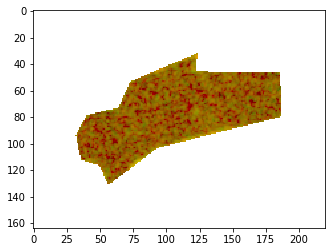

In [34]:
for session in sessions:
    for lake in lakes:
        global prev_vv
        prev_vv = []
        global prev_file
        prev_file = ""
        if lake is "":
            continue
        for orbit_pass in orbit_passes:
            input_folder = os.path.join(input_path, "rasters", sensor, session, orbit_pass, lake)
            vv_input_folder = os.path.join(input_path, "rasters", sensor, session, orbit_pass, lake, "vv")
            vh_input_folder = os.path.join(input_path, "rasters", sensor, session, orbit_pass, lake, "vh")
#             print(sorted(os.listdir(vv_input_folder), key=lambda x:x[4:]))
#             break
            for sar_image_name in sorted(os.listdir(vv_input_folder), key=lambda x:x[4:]):
                print(sar_image_name)
                if (sar_image_name.endswith('.tif') or sar_image_name.endswith('.tiff')):# and sar_image_name in os.listdir(vh_input_folder):       
                    if session in val_param or lake in val_param:
                        generate_deeplab_format(input_folder, sar_image_name, session, lake, True)
                    else:
                        generate_deeplab_format(input_folder, sar_image_name, session, lake, False)
    print("...............................................................................")
    print("water_count: {} {}".format(water_count, np.sum(water_count)))
    print("snow_count: {} {}".format(snow_count, np.sum(snow_count)))
    print("ice_count: {} {}".format(ice_count, np.sum(ice_count)))
    print("transition_count: {} {}".format(transition_count, np.sum(transition_count)))
    print("no_class_count: {} {}".format(no_class_count, np.sum(no_class_count)))
    
    
    
    water_count = [0,0,0,0]
    snow_count = [0,0,0,0]
    ice_count = [0,0,0,0]
    transition_count = [0,0,0,0]
    no_class_count = [0,0,0,0]

In [35]:
f_valtxt.close()
f_traintxt.close()
f_trainvaltxt.close()

In [36]:
print(os.getcwd())
%cd ~/lakeice/code/data_scripting
%cd ../models/research/deeplab/datasets
# print(os.getcwd())
import subprocess
# os.system('sh download_and_convert_sar_ice.sh x')
print(subprocess.check_output("sh download_and_convert_sar_ice.sh {}".format(output_name), shell=True))
%cd -

/home/pf/pfstud/Roberto_Internship/code/data_scripting
/home/pf/pfstud/Roberto_Internship/code/data_scripting
/home/pf/pfstud/Roberto_Internship/code/models/research/deeplab/datasets
b'Converting sar_ice dataset...\nProcessing val\r>> Converting image 1/357 shard 0./sar_ice/dataset_2016_17_2017_18_vv_vh_sils_silvaplana_stmoritz_2016_17/JPEGImages/_2016_09_05_0535_sils.png\nlen 79985\n[[[255 255 255]\n  [255 255 255]\n  [255 255 255]\n  ...\n  [255 255 255]\n  [255 255 255]\n  [255 255 255]]\n\n [[255 255 255]\n  [255 255 255]\n  [255 255 255]\n  ...\n  [255 255 255]\n  [255 255 255]\n  [255 255 255]]\n\n [[255 255 255]\n  [255 255 255]\n  [255 255 255]\n  ...\n  [255 255 255]\n  [255 255 255]\n  [255 255 255]]\n\n ...\n\n [[255 255 255]\n  [255 255 255]\n  [255 255 255]\n  ...\n  [255 255 255]\n  [255 255 255]\n  [255 255 255]]\n\n [[255 255 255]\n  [255 255 255]\n  [255 255 255]\n  ...\n  [255 255 255]\n  [255 255 255]\n  [255 255 255]]\n\n [[255 255 255]\n  [255 255 255]\n  [255 255 